In [77]:
import cv2 as cv
import cv2
from matplotlib import pyplot as plt
import random
import numpy as np
import time
from IPython.display import clear_output


plt.rcParams["figure.figsize"] = [10, 10]
plt.rcParams["figure.autolayout"] = True

In [78]:
img1 = cv.imread("./project2/images/t5_1.png")
img1 = cv.cvtColor(img1, cv.COLOR_BGR2RGB)

img2 = cv.imread("./project2/images/t5_2.png")
img2 = cv.cvtColor(img2, cv.COLOR_BGR2RGB)

orb = cv.ORB_create(nfeatures=2000,scoreType=cv.ORB_FAST_SCORE)

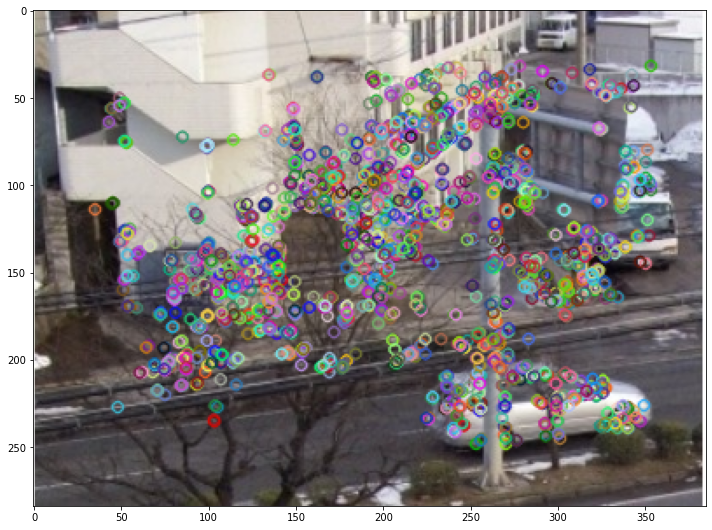

In [79]:
kp1 = orb.detect(img1,None)
kp1, des1 = orb.compute(img1, kp1)
img1x = cv.drawKeypoints(img1, kp1, None)
_ = plt.imshow(img1x)

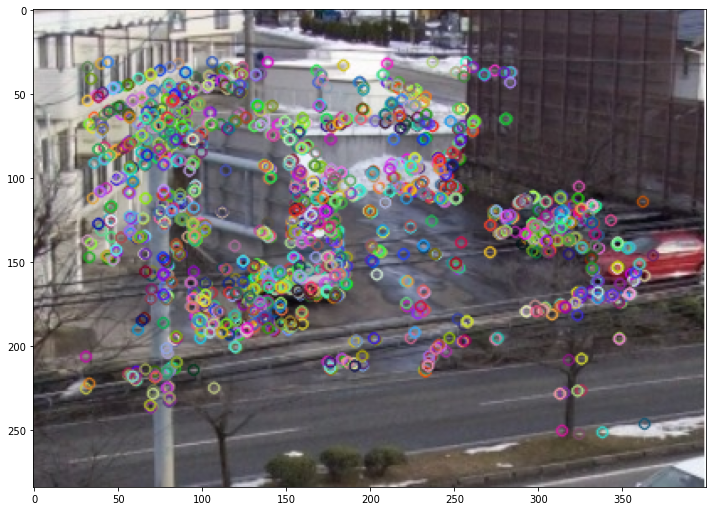

In [80]:
kp2 = orb.detect(img2,None)
kp2, des2 = orb.compute(img2, kp2)
img2x = cv.drawKeypoints(img2, kp2, None)
_ = plt.imshow(img2x)

In [81]:
def hamming_distance2(x, y):
    distance = 0
    for i,j in zip(x,y):
        distance += sum(m != n for m,n in zip(format(i,'08b'),format(j,'08b')))
    return distance

def hamming_distance(x, y):
    dis_array = x ^ y
    dis_sum = np.unpackbits(dis_array).sum()
    return float(dis_sum)

def hamming_distance3(x,y):
    diff = x ^ y
    diff = diff - ((diff >> 1) & 85)
    diff = (diff & 51) + ((diff >> 2) & 51)
    diff = (diff + (diff >> 4)) & 15
    return float(((diff * 1) >> (8 * (diff.itemsize - 1))).sum())

In [82]:
def match(des1,des2,threshold=0.7):
    matches = []
    count = 0
    length = len(des1)
    length2 = len(des2)
    for i in range(length):
        first = (float('inf'),None,None)
        second = (float('inf'),None,None)
        for j in range(length2):
            distance = hamming_distance(des1[i],des2[j])
            if distance < first[0]:
                second = first
                first = (distance,i,j)
            elif distance < second[0]:
                second = (distance,i,j)
        if first[0] < threshold * second[0]:
            matches.append(cv.DMatch(first[1],first[2],distance))
            count += 1
            
        print(f'[{i+1}/{length}] {count} matches found',end="\r")
    return matches

In [83]:
matches = match(des1,des2)

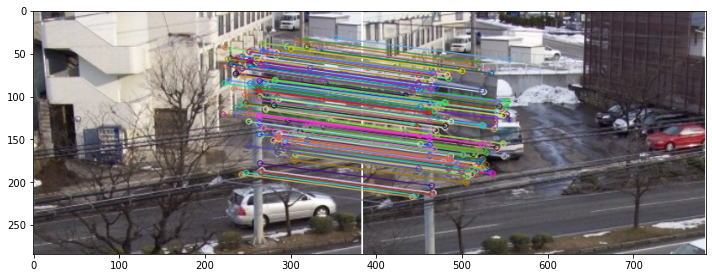

In [84]:
plt.imshow(cv.drawMatches(img1,kp1,img2,kp2,matches,None,flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS))
plt.savefig('./results/test.png',dpi=400)

In [85]:
def homo(x):
    out = (x[0],x[1],1)
    return out

def cart(x):
    out = []
    for point in x:
        if point[2] != 0:
            out.append([point[0]/point[2],point[1]/point[2]])
        else:
            out.append([0.,0.])
    return np.array(out)


def ransac(kp1,kp2,matches):
    req_prob = 1 - 1e-10
    total = len(matches)
    max_iters = 10000
    sam_pts = max(4,int(len(matches)/10))
    
    src_pts = np.float32([ homo(kp1[m.queryIdx].pt) for m in matches ])
    dst_pts = np.float32([ kp2[m.trainIdx].pt for m in matches ])
    
    max_dims = dst_pts.max(axis=0)
    
    inlier_distance = max_dims[0] * max_dims[1] /1000
    best_case = (0,None,np.zeros(total))
    i = 0
    iters = max_iters
    while iters > i:
        sample  = random.sample(matches,sam_pts)
        sample_src_pts = np.float32([ kp1[m.queryIdx].pt for m in sample ])
        sample_dst_pts = np.float32([ kp2[m.trainIdx].pt for m in sample ])
        M ,mask = cv.findHomography(sample_src_pts,sample_dst_pts)
        trans_pts = cart(np.dot(M,src_pts.transpose()).transpose())
        inliers = np.sum((trans_pts - dst_pts)**2,axis=1) < inlier_distance
        inlier_count = sum(inliers)
        if inlier_count > best_case[0]:
            best_case = (inlier_count,M,inliers)
            cal_inliers = max(3,inlier_count)
            iters = int(min(abs(np.log(1 - req_prob)/np.log(1-(cal_inliers/total)**sam_pts)),max_iters))
        i += 1
        
    print(f'{best_case[0]} inliers and {len(matches)-best_case[0]} outliers found {i}')
    
    inlier_src_pts = []
    inlier_dst_pts = []
    for i in range(len(matches)):
        if best_case[2][i]:
            inlier_src_pts.append(kp1[matches[i].queryIdx].pt)
            inlier_dst_pts.append(kp2[matches[i].trainIdx].pt)
    inlier_src_pts = np.float32(inlier_src_pts)
    inlier_dst_pts = np.float32(inlier_dst_pts)
    M ,mask = cv.findHomography(inlier_src_pts,inlier_dst_pts)
    return M

# def warp(img1, img2, M):
#     img1_dims = np.array([[[0,0]],[[0,img1.shape[0]]],[[img1.shape[1],img1.shape[0]]],[[img1.shape[1],0]]],dtype=np.float32)
#     img2_dims = np.array([[[0,0]],[[0,img2.shape[0]]],[[img2.shape[1],img2.shape[0]]],[[img2.shape[1],0]]],dtype=np.float32)
#     img2_trans_dims = cv.perspectiveTransform(img2_dims, M)
#     final_img_dims = np.concatenate((img1_dims, img2_trans_dims), axis=0)
#     [xmin, ymin] = np.int32(final_img_dims.min(axis=0).ravel() - 0.5)
#     [xmax, ymax] = np.int32(final_img_dims.max(axis=0).ravel() + 0.5)
#     Mx = np.array([[1,0,-xmin],[0,1,-ymin],[0,0,1]])
#     img2_out = cv.warpPerspective(img2, Mx.dot(M), (xmax-xmin, ymax-ymin),borderMode=cv.BORDER_TRANSPARENT)
#     img1_out = np.pad(img1,((-ymin,img2_out.shape[0]-(img1.shape[0]-ymin)),(-xmin,img2_out.shape[1]-(img1.shape[1]-xmin)),(0,0)))
#     return img1_out,img2_out

def warp(img1, img2, M):
    img1_dims = np.float32([[0,0],[0,img1.shape[0]],[img1.shape[1],img1.shape[0]],[img1.shape[1],0]]).reshape(-1,1,2)
    img2_dims = np.float32([[0,0],[0,img2.shape[0]],[img2.shape[1],img2.shape[0]],[img2.shape[1],0]]).reshape(-1,1,2)
    img2_trans_dims = cv2.perspectiveTransform(img2_dims, M)
    final_img_dims = np.concatenate((img1_dims, img2_trans_dims), axis=0)
    [xmin, ymin] = np.int32(final_img_dims.min(axis=0).ravel() - 0.5)
    [xmax, ymax] = np.int32(final_img_dims.max(axis=0).ravel() + 0.5)
    Mx = np.array([[1,0,-xmin],[0,1,-ymin],[0,0,1]]) 
    img2_out = cv2.warpPerspective(img2, Mx.dot(M), (xmax-xmin, ymax-ymin))
    img1_out = np.pad(img1,((-ymin,img2_out.shape[0]-(img1.shape[0]-ymin)),(-xmin,img2_out.shape[1]-(img1.shape[1]-xmin)),(0,0)))
    return img1_out,img2_out

def combine(img1,img2):
    h,w,t = img1.shape
    out = np.zeros(img1.shape)
    for i in range(h):
        for j in range(w):
            for k in range(t):
                out[i,j,k] = img1[i,j,k] or img2[i,j,k]
    return out.astype(int)

def mask(img1,img2):
    gray1 = 0.2989 * img1[:,:,0] + 0.5870 * img1[:,:,1] + 0.1140 * img1[:,:,2]
    gray2 = 0.2989 * img2[:,:,0] + 0.5870 * img2[:,:,1] + 0.1140 * img2[:,:,2]
    return np.logical_xor(gray1,gray2).astype(int),np.logical_and(gray1,gray2).astype(int)

def mask2(img1,img2):
    gray1 = 0.2989 * img1[:,:,0] + 0.5870 * img1[:,:,1] + 0.1140 * img1[:,:,2]
    gray2 = 0.2989 * img2[:,:,0] + 0.5870 * img2[:,:,1] + 0.1140 * img2[:,:,2]
    mask2 = np.logical_and(np.logical_xor(gray1,gray2),np.logical_not(gray1)) * 1
    return mask2.astype(int),np.logical_and(gray1,gray2).astype(int)

def deghost(img1,img2,mask_xor,mask_and,blend=5):
    w = img1.shape[1]
    same = np.zeros(img1.shape)
    ref = np.zeros(img1.shape)
    mask_and = np.tile(mask_and[...,None],3)
    mask_xor = np.tile(mask_xor[...,None],3)
    same[:,0,:] = img1[:,0,:] * mask_and[:,0,:]
    ref[:,0,:] = img1[:,0,:] * mask_and[:,0,:]
    last = 1
    w1 = 1
    w2 = 0
    for i in range(1,w):
        val1 = ((img1[:,i,:] - ref[:,i-1,:]) * mask_and[:,i,:]).sum()
        val2 = ((img2[:,i,:] - ref[:,i-1,:]) * mask_and[:,i,:]).sum()
        if val1 > val2:
            if last == 2:
                w1,w2 = 0.2,0.8
            else:
                w1 = np.clip(w1 + 1/blend,0,1)
                w2 = np.clip(w2 - 1/blend,0,1)
            same[:,i,:] = w1 * img1[:,i,:] * mask_and[:,i,:] + w2 * img2[:,i,:] * mask_and[:,i,:]
            ref[:,i,:] = img1[:,i,:] * mask_and[:,i,:] 
            last = 1
        else:
            if last == 1:
                w1,w2 = 0.8,0.2
            else:
                w1 = np.clip(w1 - 1/blend,0,1)
                w2 = np.clip(w2 + 1/blend,0,1)
            same[:,i,:] = w1 * img1[:,i,:] * mask_and[:,i,:] + w2 * img2[:,i,:] * mask_and[:,i,:] 
            ref[:,i,:] = img2[:,i,:] * mask_and[:,i,:]
            last = 2
    diff = (img1 + img2) * mask_xor
    return (same + diff).astype(int)


def deghost1(img0,img1,mask_xor,mask_and,size=5):
    h,w = img0.shape[:2]
    refh = np.zeros(img0.shape)
    refw = np.zeros(img0.shape)
    mask_andt = np.tile(mask_and[...,None],3)
    refw[:,0,:] = img0[:,0,:] * mask_andt[:,0,:]
    trackerw = [0]
    
    last = 0
    for i in range(1,w):
        val0 = ((img0[:,i,:] - refw[:,i-1,:]) * mask_andt[:,i,:]).sum()
        val1 = ((img1[:,i,:] - refw[:,i-1,:]) * mask_andt[:,i,:]).sum()
        if val0 > val1:
            refw[:,i,:] = img0[:,i,:] * mask_andt[:,i,:]
            if last == 1:
                trackerw.append(i)
                last = 0
        else:
            refw[:,i,:] = img1[:,i,:] * mask_andt[:,i,:]
            if last == 0:
                trackerw.append(i)
                last = 1
    if trackerw[-1] != w:
        trackerw.append(w)
    
    refh = []
    trackerh = []
    for i in range(1,len(trackerw)):
        x = np.zeros((h,trackerw[i]-trackerw[i-1],3))
        x[0,:,:] = img0[0,trackerw[i-1]:trackerw[i],:]
        refh.append(x)
        trackerh.append(np.zeros((h,trackerw[i]-trackerw[i-1])))
    
    for i,(col,trackh_col) in enumerate(zip(refh,trackerh)):
        for j in range(1,h):         
            val0 = ((img0[j,trackerw[i]:trackerw[i+1],:] - col[j-1,:,:]) * mask_andt[j,trackerw[i]:trackerw[i+1],:]).sum()
            val1 = ((img1[j,trackerw[i]:trackerw[i+1],:] - col[j-1,:,:]) * mask_andt[j,trackerw[i]:trackerw[i+1],:]).sum()
            
            if val0 > val1:
                col[j,:,:] = img0[j,trackerw[i]:trackerw[i+1],:] * mask_andt[j,trackerw[i]:trackerw[i+1],:]
                trackh_col[j,:] = 0 #* mask_and[j,trackerw[i]:trackerw[i+1]]
                
            else:
                col[j,:,:] = img1[j,trackerw[i]:trackerw[i+1],:] * mask_andt[j,trackerw[i]:trackerw[i+1],:]
                trackh_col[j,:] = 1 #* mask_and[j,trackerw[i]:trackerw[i+1]]
        refh[i] = col.astype('uint8')
        trackerh[i] = trackh_col.astype('uint8')
        
    img1_mask = (np.hstack(trackerh) * mask_and) + mask_xor
    img0_mask = np.logical_not(img1_mask)
            
    img1_mask = np.tile(img1_mask[...,None],3)
    img0_mask = np.tile(img0_mask[...,None],3)
    return (img0_mask * img0 +img1_mask * img1).astype('uint8')
    # return img1_mask + img0_mask
    

In [86]:
src_pts = np.float32([ kp1[m.queryIdx].pt for m in matches ])
dst_pts = np.float32([ kp2[m.trainIdx].pt for m in matches ])

In [87]:
M = ransac(kp1,kp2,matches)

259 inliers and 0 outliers found 1


C:\Users\naine\AppData\Local\Temp\ipykernel_25136\3613122659.py:41: RuntimeWarning: divide by zero encountered in log
  iters = int(min(abs(np.log(1 - req_prob)/np.log(1-(cal_inliers/total)**sam_pts)),max_iters))


In [88]:
a,b = warp(img2,img1,M)

In [89]:
x,y = mask(a,b)

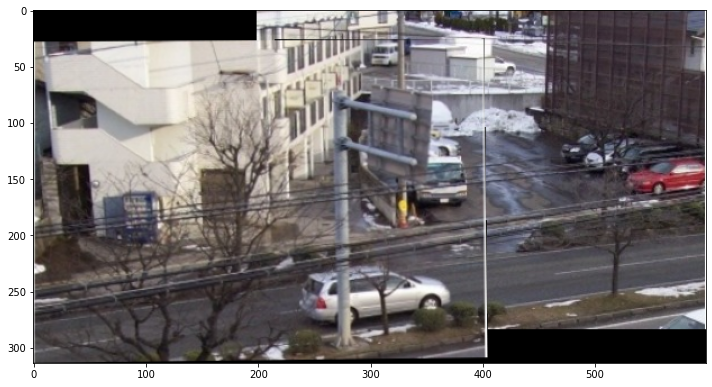

In [90]:
plt.imshow(deghost(a,b,x,y,5))
plt.savefig('./results/deghost.png')

In [91]:
x,y = mask2(a,b)
res = deghost1(a,b,x,y,9)

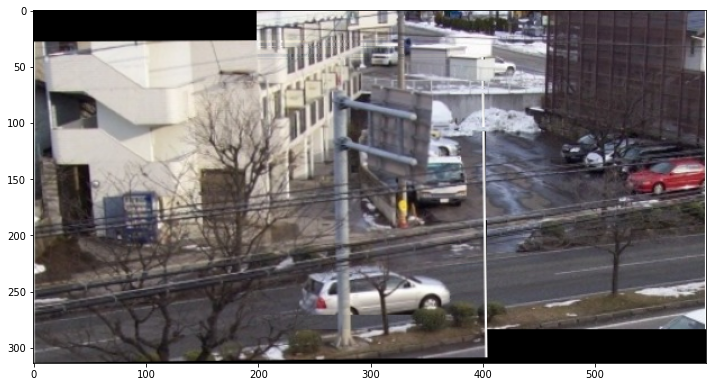

In [92]:
plt.imshow(res,cmap='gray')
plt.savefig('./results/final.png')

In [93]:
cal_inliers = 120
total = 120
sam_pts = 4
np.log(1-(cal_inliers/total)**sam_pts)

C:\Users\naine\AppData\Local\Temp\ipykernel_25136\3384744844.py:4: RuntimeWarning: divide by zero encountered in log
  np.log(1-(cal_inliers/total)**sam_pts)


-inf

In [94]:
np.eye(3)

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])